In [87]:
import gymnasium as gym
import numpy as np
import math

In [88]:
import sys
print(sys.executable)

/usr/local/bin/python


In [89]:
env = gym.make("CartPole-v1")
print(env.observation_space.high, env.observation_space.low, env.action_space.n, sep="\n")

[4.8               inf 0.41887903        inf]
[-4.8               -inf -0.41887903        -inf]
2


In [90]:
#hyperparameters
EPISPODES = 40000
DISCOUNT = 0.95
EP_DISPLAY = 2000
LR = 0.2
EPSILON = 0.2 #p to explore

theta_lim = env.observation_space.high[2]
theta_dot_lim = math.radians(50)
theta_state_size = 50
theta_dot_state_size = 50

Q_table = np.random.randn(theta_state_size, theta_dot_state_size, env.action_space.n)

ep_rewards = []
ep_rewards_table = {'ep':[], 'avg':[], 'min':[], 'max':[]}

In [91]:
def discretised_state(state):
    discretised_state = np.array([0,0]) #theta, theta dot
    theta_window = 2*theta_lim/theta_state_size
    discretised_state[0] = min(theta_state_size-1, max(0, (state[2]+theta_lim)//theta_window))

    theat_dot_window = 2*theta_dot_lim/theta_dot_state_size
    discretised_state[1] = min(theta_dot_state_size-1, max(0, (state[3]+theta_dot_lim)//theat_dot_window))

    return tuple(discretised_state.astype(np.int64))


In [92]:
for ep in range(EPISPODES):
    ep_reward = 0
    flag = False

    obs, _ = env.reset()
    curr_discrete_state = discretised_state(obs)
    
    if np.random.random() > EPSILON:
        action = np.argmax(Q_table[curr_discrete_state])
    else:
        action = np.random.randint(0, env.action_space.n)

    while not flag:
        next_state, reward, terminated, truncated, _ = env.step(action)
        flag = terminated or truncated

        new_discrete_state = discretised_state(next_state)

        if np.random.random() > EPSILON:
            new_action = np.argmax(Q_table[new_discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)

        if ep%EP_DISPLAY == 0:
            env.render()
        
        if not flag:
            curr_q = Q_table[curr_discrete_state+(action, )]
            max_future_q = Q_table[new_discrete_state+(new_action, )]
            new_q = curr_q + LR*(reward+DISCOUNT*max_future_q - curr_q)
            Q_table[curr_discrete_state+(action, )] = new_q
        
        curr_discrete_state = new_discrete_state
        action = new_action

        ep_reward += reward
    ep_rewards.append(ep_reward)
    
    if ep % EP_DISPLAY == 0:
        avg_reward = sum(ep_rewards[-EP_DISPLAY:])/len(ep_rewards[-EP_DISPLAY:])
        ep_rewards_table['ep'].append(ep)
        ep_rewards_table['avg'].append(avg_reward)
        ep_rewards_table['min'].append(min(ep_rewards[-EP_DISPLAY:]))
        ep_rewards_table['max'].append(max(ep_rewards[-EP_DISPLAY:]))
        print(f"Episode;{ep} avg:{avg_reward} min:{min(ep_rewards[-EP_DISPLAY:])} max:{max(ep_rewards[-EP_DISPLAY:])}")

env.close()


Episode;0 avg:12.0 min:12.0 max:12.0
Episode;2000 avg:15.37 min:8.0 max:65.0
Episode;4000 avg:16.1785 min:8.0 max:96.0
Episode;6000 avg:20.9495 min:8.0 max:111.0
Episode;8000 avg:28.425 min:8.0 max:185.0
Episode;10000 avg:40.1 min:8.0 max:276.0
Episode;12000 avg:58.238 min:9.0 max:387.0
Episode;14000 avg:84.7295 min:9.0 max:500.0
Episode;16000 avg:153.0955 min:9.0 max:500.0
Episode;18000 avg:230.2515 min:9.0 max:500.0
Episode;20000 avg:246.703 min:10.0 max:500.0
Episode;22000 avg:238.9045 min:9.0 max:500.0
Episode;24000 avg:259.442 min:8.0 max:500.0
Episode;26000 avg:255.517 min:10.0 max:500.0
Episode;28000 avg:246.2165 min:9.0 max:500.0
Episode;30000 avg:250.6275 min:10.0 max:500.0
Episode;32000 avg:274.453 min:9.0 max:500.0
Episode;34000 avg:233.8125 min:9.0 max:500.0
Episode;36000 avg:236.77 min:9.0 max:500.0
Episode;38000 avg:258.859 min:9.0 max:500.0


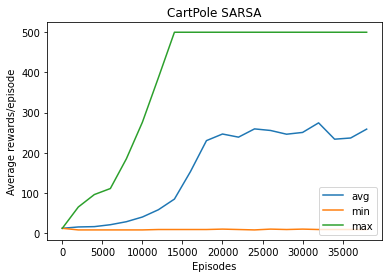

In [93]:
import matplotlib.pyplot as plt

plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label='avg')
plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label='min')
plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label='max')
plt.legend(loc=4)
plt.title('CartPole SARSA')
plt.ylabel('Average rewards/episode')
plt.xlabel('Episodes')
plt.show()